In [140]:
import sqlite3
from sqlite3 import Error
import sqlalchemy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bq_helper
from bq_helper import BigQueryHelper
usfs = BigQueryHelper(active_project="bigquery-public-data",
                                   dataset_name="usfs_fia")
from matplotlib import dates
import seaborn as sns

In [141]:
#function for creating the dates for the x-axis for regression plots
@plt.FuncFormatter
def fake_dates(x, pos):
    """ Custom formater to turn floats into e.g., 2016-05-08"""
    return dates.num2date(x).strftime('%Y-%m-%d')


In [142]:
usfs.list_tables()

['condition',
 'estimated_forestland_acres',
 'estimated_timberland_acres',
 'plot',
 'plot_tree',
 'population',
 'population_estimation_unit',
 'population_evaluation',
 'population_evaluation_group',
 'population_evaluation_type',
 'population_stratum',
 'population_stratum_assign',
 'tree']

See what's in plot_tree

In [143]:
usfs.table_schema('tree')

,name,type,mode,description
0,tree_sequence_number,INTEGER,NULLABLE,Foreign key linking the tree regional biomass ...
1,plot_sequence_number,INTEGER,NULLABLE,Foreign key linking the subplot record to the ...
2,previous_tree_sequence_number,INTEGER,NULLABLE,Foreign key linking the tree to the previous i...
3,tree_inventory_year,INTEGER,NULLABLE,The year that best represents when the invento...
4,tree_state_code,INTEGER,NULLABLE,Bureau of the Census Federal Information Proce...
...,...,...,...,...
250,inc5yrht_pnwrs,STRING,NULLABLE,
251,inc5yr_pnwrs,STRING,NULLABLE,
252,ring_count_inner_2inches_pnwrs,STRING,NULLABLE,
253,ring_count_pnwrs,STRING,NULLABLE,


From the description, find the code of the tree (is it unique?)

In [144]:
usfs.table_schema('tree')[usfs.table_schema('tree')["description"] == "An identifier for a plot. Along with state code, inventory year, tree survey unit code, County code and/or some other combinations of variables, PLOT may be used to uniquely identify a plot."].index.tolist()

[7]

In [145]:
usfs.table_schema('plot_tree').head(25)

,name,type,mode,description
0,plot_sequence_number,INTEGER,NULLABLE,Foreign key linking the subplot record to the ...
1,survey_sequence_number,INTEGER,NULLABLE,Foreign key linking the plot record to the sur...
2,county_sequence_number,INTEGER,NULLABLE,Foreign key linking the snapshot record to the...
3,previous_plot_sequence_number,INTEGER,NULLABLE,Foreign key linking the plot record to the pre...
4,plot_inventory_year,INTEGER,NULLABLE,The year that best represents when the invento...
5,plot_state_code,INTEGER,NULLABLE,Bureau of the Census Federal Information Proce...
6,plot_state_code_name,STRING,NULLABLE,Bureau of the Census Federal Information Proce...
7,plot_survey_unit_code,INTEGER,NULLABLE,Forest Inventory and Analysis survey unit iden...
8,plot_county_code,INTEGER,NULLABLE,"The identification number for a county, parish..."
9,plot_phase_2_plot_number,INTEGER,NULLABLE,An identifier for a plot. Along with tree stat...


In [159]:
usfs.table_schema('tree')["description"][9]

'A number used to uniquely identify a tree on a subplot. Tree numbers can be used to track trees when PLOT.DESIGNCD is the same between inventories.'

Found that it corresponds to "tree_phase_2_plot_number"

In [147]:
for i in usfs.table_schema('tree')["name"]:
    print(i)

tree_sequence_number
plot_sequence_number
previous_tree_sequence_number
tree_inventory_year
tree_state_code
tree_survey_unit_code
tree_county_code
tree_phase_2_plot_number
subplot_number
tree_record_number
condition_class_number
azimuth
horizontal_distance
previous_condition_number
tree_status_code
tree_status_code_name
species_code
species_common_name
species_scientific_name
species_group_code
species_group_code_name
current_diameter
diameter_height_code
diameter_height_code_name
total_height
height_method_code
height_method_code_name
actual_height
tree_class_code
tree_class_code_name
compacted_crown_ratio
crown_class_code
crown_class_code_name
tree_grade_code
cause_death_agent_code
cause_death_agent_code_name
rotten_and_missing_cull
damage_location_1
damage_location_1_name
damage_type_1
damage_type_1_name
damage_severity_1
damage_severity_1_name
damage_location_2
damage_location_2_name
damage_type_2
damage_type_2_name
damage_severity_2
damage_severity_2_name
decay_class_code
decay_cl

In [148]:
query1 = f"""
    SELECT
        species_common_name,
        plot_state_code_name,
        plot_phase_2_plot_number,
        measurement_month,
        measurement_year,
        current_diameter as avg_dia,
        total_height as avg_heig,
        
    FROM
        `bigquery-public-data.usfs_fia.plot_tree`
    WHERE
        total_height > 0
        AND plot_state_code_name = 'California'
    GROUP BY
        species_common_name,
        plot_state_code_name,
        plot_phase_2_plot_number,
        measurement_month,
        measurement_year,
        current_diameter,
        total_height
    ;        """
response1 = usfs.query_to_pandas_safe(query1, max_gb_scanned=10)

In [149]:
response1['date'] = pd.to_datetime({'year':response1['measurement_year'],'month':response1['measurement_month'],'day': np.ones(response1["measurement_year"].size)})
# response1.head()
len(response1)

335747

In [150]:
response1.plot_phase_2_plot_number.value_counts()

28       547
18       444
55       432
24       430
25       419
        ... 
60142      1
97101      1
54833      1
51911      1
57192      1
Name: plot_phase_2_plot_number, Length: 6083, dtype: int64

In [151]:
response1[response1.species_common_name == "Pacific madrone"]

,species_common_name,plot_state_code_name,plot_phase_2_plot_number,measurement_month,measurement_year,avg_dia,avg_heig,date
46,Pacific madrone,California,153,11,1991,2.800000,23,1991-11-01
52,Pacific madrone,California,184,7,1991,6.200000,46,1991-07-01
84,Pacific madrone,California,141,7,1991,9.700000,54,1991-07-01
135,Pacific madrone,California,3,10,1991,14.100000,69,1991-10-01
249,Pacific madrone,California,106,8,1991,2.000000,17,1991-08-01
...,...,...,...,...,...,...,...,...
335527,Pacific madrone,California,73243,5,2018,9.900000,39,2018-05-01
335654,Pacific madrone,California,97409,10,2018,9.300000,33,2018-10-01
335670,Pacific madrone,California,88939,7,2018,9.000000,66,2018-07-01
335720,Pacific madrone,California,82034,7,2018,15.200000,39,2018-07-01


In [152]:
# sugar_maple = response1.loc[(response1.plot_phase_2_plot_number == 33) & (response1.species_common_name =="Pacific madrone")]

pacific_madrone = response1.loc[(response1.plot_phase_2_plot_number == 28) & (response1.species_common_name =="Pacific madrone")]
pacific_madrone.plot_phase_2_plot_number.value_counts()


28    6
Name: plot_phase_2_plot_number, dtype: int64

In [153]:
# pacific_madrone.loc[(pacific_madrone.avg_heig>100) & (pacific_madrone.plot_phase_2_plot_number == 57038)]
taller = pacific_madrone.loc[(pacific_madrone.avg_heig>50)]


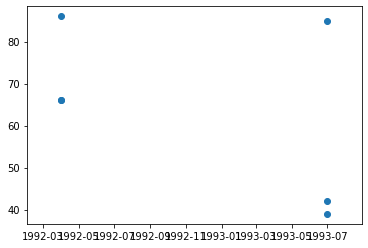

In [154]:
# sns.lmplot(data = taller, x = "date",y = "avg_heig")
plt.scatter(pacific_madrone["date"], pacific_madrone["avg_heig"])

In [155]:
#convert to something that sns.regplot can handle
date_maple = dates.datestr2num(sugar_maple.date.astype(str))
sugar_maple_dtn = sugar_maple.copy()
sugar_maple_dtn['dtn'] = date_maple

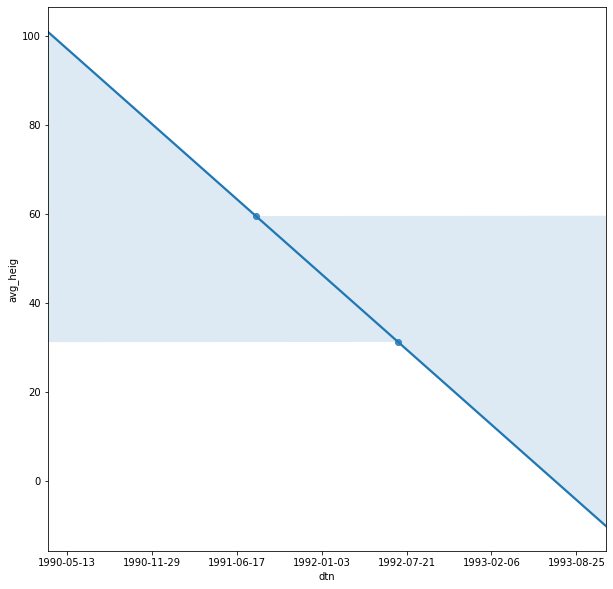

In [156]:
fig, ax = plt.subplots(figsize = (10,10))
sns.regplot(data = sugar_maple_dtn, x = "dtn",y = "avg_heig")
ax.xaxis.set_major_formatter(fake_dates)


In [158]:
query2 = """
SELECT
    current_diameter as avg_dia,
    total_height as avg_heig,
    measurement_year,
    plot_county_code,
    tree_phase_2_plot_number,
    subplot_number,
    tree_record_number
FROM
    `bigquery-public-data.usfs_fia.tree`
WHERE
    total_height > 0
    AND tree_state_code = 4
GROUP BY
    plot_county_code,
    measurement_year,
    tree_phase_2_plot_number,
    subplot_number,
    tree_record_number,
    current_diameter,
    total_height
;        """
response2 = usfs.query_to_pandas_safe(query2, max_gb_scanned=10)

BadRequest: 400 POST https://bigquery.googleapis.com/bigquery/v2/projects/erdosinstituteprojectjt/jobs: Unrecognized name: measurement_year at [5:5]

(job ID: 50db3226-8908-4d3f-8fdf-0814d6b109d5)

       -----Query Job SQL Follows-----       

    |    .    |    .    |    .    |    .    |
   1:
   2:SELECT
   3:    current_diameter as avg_dia,
   4:    total_height as avg_heig,
   5:    measurement_year,
   6:    plot_county_code,
   7:    tree_phase_2_plot_number,
   8:    subplot_number,
   9:    tree_record_number
  10:FROM
  11:    `bigquery-public-data.usfs_fia.tree`
  12:WHERE
  13:    total_height > 0
  14:    AND tree_state_code = 4
  15:GROUP BY
  16:    plot_county_code,
  17:    measurement_year,
  18:    tree_phase_2_plot_number,
  19:    subplot_number,
  20:    tree_record_number,
  21:    current_diameter,
  22:    total_height
  23:;        
    |    .    |    .    |    .    |    .    |

In [ ]:
len(response2.plot_county_code.value_counts())

In [ ]:
jackson_count = response2[response2.plot_county_code == 141]

In [ ]:
jackson_count.tail()

In [ ]:
import seaborn as sns
sns.lmplot(data = jackson_count,x = "measurement_year",y = "avg_heig")

In [ ]:
query3 = """
SELECT
    tree_phase_2_plot_number,
    total_height as avg_heig,
    measurement_year,
    measurement_month,
    plot_county_code
FROM
    `bigquery-public-data.usfs_fia.plot_tree`
WHERE
    plot_state_code = 39
    AND total_height > 0

;        """
response3 = usfs.query_to_pandas_safe(query3, max_gb_scanned=10)